# Mapping Representations

Recall that we can think of a deep model learning as series of new "representations" at each layer of its processing, each representation making the overall solution that the network is trying to achieve easier. We can understand what the information the representations at each layer captures by mapping the representations in a 2-dimensional scatter plot that we can inspect.

In [1]:
import numpy as np

from sklearn.manifold import TSNE

from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K

import matplotlib
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Data

## MNIST overview

Let"s download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(len(X_train), "train samples")
print(len(X_test), "test samples")

11370496/11490434 [============================>.] - ETA: 0s60000 train samples
10000 test samples


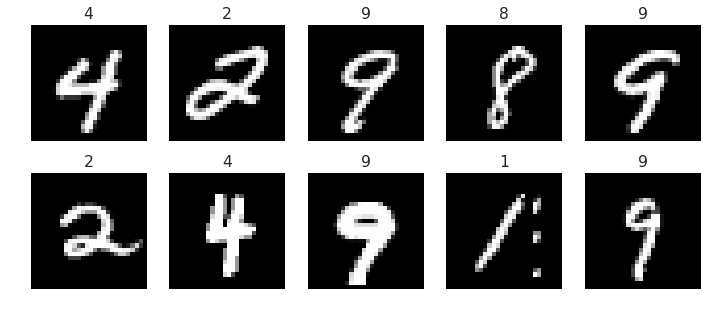

In [5]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let"s see objects are distributed among classes

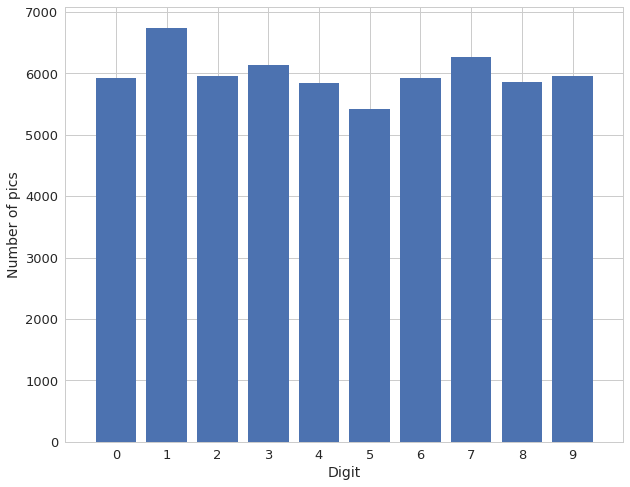

In [6]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(0, 10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14);

As one can see, the task is pretty balanced

## Data preparation

First of all, let"s predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [7]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

In [8]:
X_train.shape

(60000, 28, 28)

The thing that is different in Theano and Tensorflow is order of these dimensions inside tensor.

With Theano yo"re going to have 4-dimensional tensor with the following dimensions: **(Objects, Channels, Image rows,Image columns)**. Assume that $\text{X_train}$ is our tensor. Then $\text{X_train}[0]$ gives you one trainig object - it is an image with few channels in general case. $\text{X_train}[0][0]$ gives you the first channel of the first object. And so on. The logic of tensors should be clear now.

In Tensorflow the order is the following: **(Objects, Image rows, Image columns, Channels)**

We"re using TF as a backend but the pre-trained model was trained with Theano. So we should count for it and reshape the data in the corresponding manner.

In [9]:
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

Now the vectors are flattened

In [10]:
X_train.shape

(60000, 1, 28, 28)

Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let"s have our data in $[0; 1]$ interval $-$ it"s common choice for grayscale images.

In [11]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

# Model

First we will load the MNIST model we trained beforehand.

Architecture can be downloaded from [here](https://www.dropbox.com/sh/6pqwz12vzx333as/AACa9ezSFhpa7f64EeAFgP96a/mnist_cnn.json?dl=0) and weights are [here](https://www.dropbox.com/sh/6pqwz12vzx333as/AADp-f8K7UjJNC_VYZeCY0Uia?dl=0&preview=mnist_cnn_weights.h5)

Load model architecture

In [19]:
import os
print(os.path.abspath("."))
model = model_from_json(open("mnist_cnn.json").read())

/root/shared/DeepLearning/dl3executives/Labs/Unit03_TSNE_MNIST


/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py:1252: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 1, ..., activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_first", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py:1252: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_first", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use

Then let"s load model weights

In [20]:
model.load_weights("mnist_cnn_weights.h5")

And finally recompile the model

In [21]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# tSNE

[tSNE](https://lvdmaaten.github.io/tsne/) is a commonly used visualization tool in deep learning. It is a dimensionality reduction technique: it takes high-dimensional data and maps them into a 2-dimensional space such that the relationships of the data is preserved. We call this low-dimensional mapping an "embedding".

Below is a function that creates a plot of an embedding. We will soon see what it looks like and how to interpret it.

In [22]:
def plot_embedding(imgs, X, y, title=None):
    # adapted from http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # зlot colors numbers
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={"weight": "bold", "size": 9})

    # add image overlays
    if hasattr(offsetbox, "AnnotationBbox"):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don"t show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    
    plt.xticks([]), plt.yticks([])
    
    if title is not None:
        plt.title(title)

tSNE takes a list of representations for each example data as input and outputs a 2-d location for that example. Below, we do this to the input data itself and plot the result. Read and run the steps below.

## Embed raw MNIST images into 2 dimensions

We need select the data to embed - in this case the first 1000 training examples. Then we reshape the data from its $28 \times 28$ size to a flat vector

In [23]:
num_emb = 1000
reps = X_train[:num_emb].reshape([num_emb, img_rows * img_cols])
print(reps.shape)

(1000, 784)


Fit our tSNE mapping to the `reps` data vectors

In [24]:
tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=3000)
emb = tsne.fit_transform(reps)

To make the plot, we input the image data itself, the embedding data we fit with tSNE and class labels for the the data points

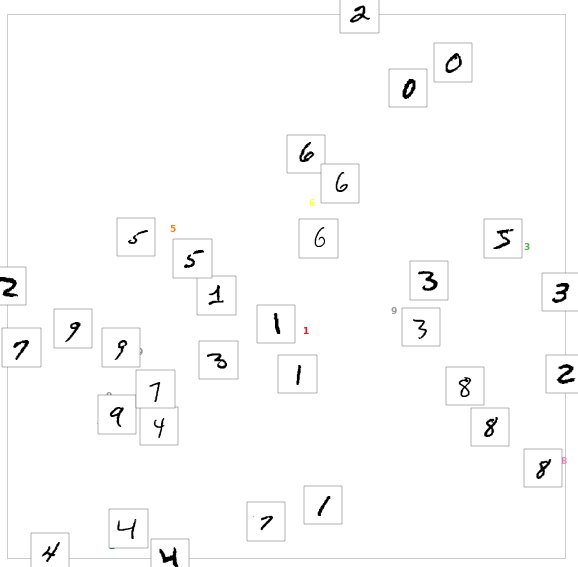

In [25]:
num_plot = 50 # 50 examples
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])

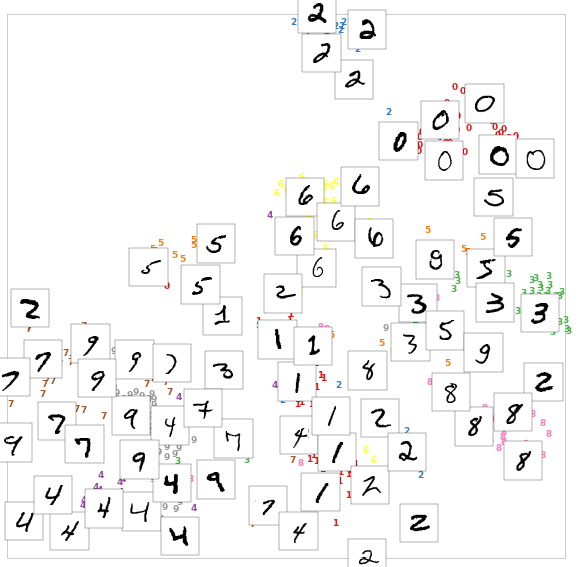

In [26]:
num_plot = 500 # 500 examples
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])

### Q1: interpreting a tSNE plot

Inspect the plot of the raw input data. What do you observe?

tSNE tries to preserve the distances of the data: if points are close to each other in the representation, tSNE tries to keep them close to each other in the embedding.

How do you think this plot might look different if the numbers in our dataset were not centered in the image? Why?

## Visualizing deep representations

We will now do the same as we did above, but instead of using the raw input data as our representation, we will use the hidden layer activations of your model as the representation.

Here are the layers we can choose to visualize:

In [27]:
model.layers

Here is the function we can use to extract layer outputs. Right now it extracts activations from the first layer. More information on this feature of Keras can be found [here](http://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer).

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution2d_1 (Conv2D)     (None, 32, 26, 26)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 26, 26)        0         
_________________________________________________________________
convolution2d_2 (Conv2D)     (None, 32, 24, 24)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 24, 24)        0         
_________________________________________________________________
maxpooling2d_1 (MaxPooling2D (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

Process the training data and pass it thru the NN and take the output and plot the data in this new space (project it down first though)

In [29]:
# define a TF funcition that takes the input data, 
# pass it thru the NN and take the output from the first (convolutional) layer
get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[1].output])
# process the data
reps = get_layer([X_train[:num_emb], 0])[0]
print(reps.shape)

(1000, 32, 26, 26)


The deeper we go thru the network the better representation we get. So let"s take features from the very last layer (before `softmax`) and see how classes are separated

In [30]:
# define a TF funcition that takes the input data, 
# pass it thru the NN and take the output from the first (convolutional) layer
get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[10].output])
# process the data
reps = get_layer([X_train[:num_emb], 0])[0]
print(reps.shape)

(1000, 10)


Create a tSNE plot with a deep fully-connected layer. Fit our tSNE mapping to the `reps` data vectors

In [31]:
tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=3000)
emb = tsne.fit_transform(reps)

To make the plot, we input the image data itself, the embedding data we fit with tSNE, and class labels for the the data points

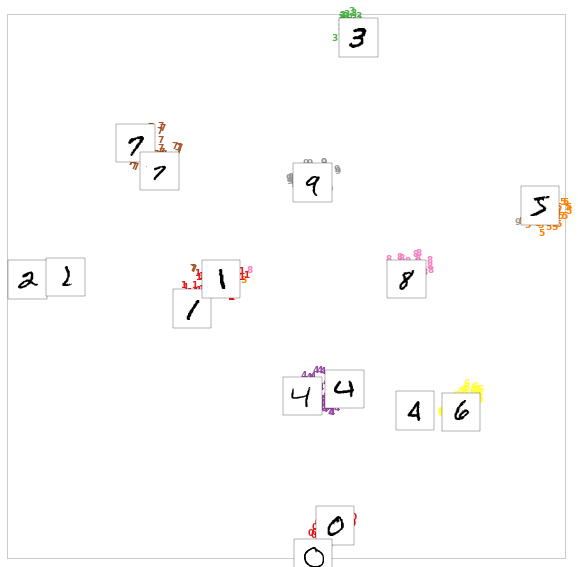

In [32]:
num_plot = 500 # 500 examples
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])

What do you observe?
1. Characterize the difference between this plot and the prior plot.
2. Can you find any "mistakes" in this plot?
3. You might notice clusters of data. Do the relationship between these clusters in the plot seem sensible to you? Can you explain this?

### Q2: map a middle layer

Choose another layer in your model and map it as above. You can choose another "flat layer" if your model has one, or you can choose a convolutional layer (in fact, it is interesting to try both). If you choose a convolutional layer, remember you will need to reshape the representations so that they are flat before doing tSNE.

Compared to earlier plots, is there a noticeable difference? Can you explain the relationship among all of the plots we have made?

In [33]:
# Map another hidden layer lower in the network
# define a TF funcition that takes the input data, 
# pass it thru the NN and take the output from the first (convolutional) layer
get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[8].output])
# process the data
reps = get_layer([X_train[:num_emb], 0])[0]
print(reps.shape)

(1000, 128)


In [34]:
tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=3000)
emb = tsne.fit_transform(reps)

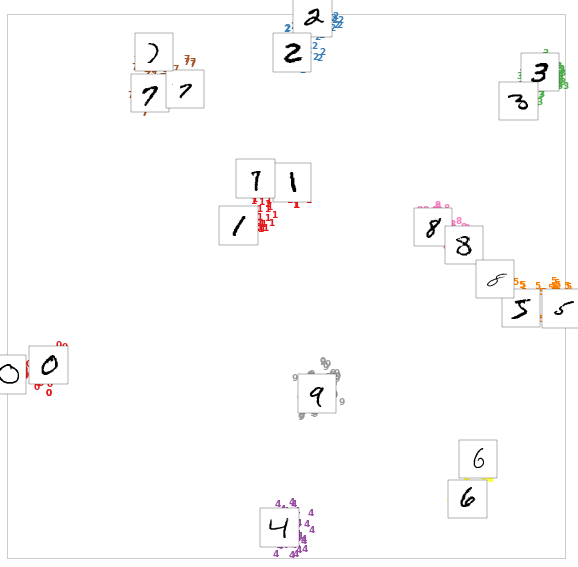

In [35]:
num_plot = 500 # 500 examples
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])